This requires xqml having set up and working. 

In [1]:
from __future__ import division

import numpy as np
import healpy as hp
from pylab import *
import timeit
import sys

import xqml
from xqml.xqml_utils import progress_bar, getstokes
from xqml.simulation import Karcmin2var
from xqml.simulation import extrapolpixwin

In [2]:
import importlib
import global_params as gp
importlib.reload(gp)

<module 'global_params' from '/home/shotinli/xQML/xqml_redo/global_params.py'>

In [3]:
nside = gp.nside
bool_thresh = gp.bool_thresh
lmin = gp.lmin
lmax = gp.lmax
dell = gp.dell
npixtot = gp.npixtot
fwhm = gp.fwhm
pixwin = gp.pixwin
muKarcmin = gp.muKarcmin

print('nside =',nside)
print('bool_thresh =',bool_thresh)
print('lmin =',lmin)
print('lmax =',lmax)
print('dell =',dell)
print('npixtot =',npixtot)
print('fwhm =',fwhm)
print('pixwin =',pixwin)

nside = 8
bool_thresh = 0.5
lmin = 2
lmax = 23
dell = 1
npixtot = 768
fwhm = 0.05
pixwin = True


In [4]:
verbose = True

In [5]:
stokes, spec, istokes, ispecs = getstokes(spec=['TT', 'EE', 'BB', 'TE', 'EB', 'TB'])

if verbose: 
    print('stokes:', stokes)
    print('spec:', spec)
    print('istokes:', istokes)
    print('ispecs:', ispecs)

stokes: ['I', 'Q', 'U']
spec: ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
istokes: [0, 1, 2]
ispecs: [0, 1, 2, 3, 5, 4]


In [6]:
nstokes = len(stokes)
nspec = len(spec)
if verbose:
    print('nstokes:', nstokes)
    print('nspec:', nspec)

nstokes: 3
nspec: 6


In [7]:
mask = np.load("/gpfs/shotinli/unwisemask_Feb23.npy",allow_pickle=True)

In [8]:
mask = hp.pixelfunc.ud_grade(mask, nside)
mask[mask<bool_thresh]=0
mask[mask>bool_thresh]=1

In [9]:
bins = xqml.Bins.fromdeltal(lmin, lmax, dell)

In [10]:
Slmax = int(bins.lmax) if lmax is None else int(lmax)

In [11]:
bl = hp.gauss_beam(fwhm, lmax=Slmax)

In [12]:
bell = None
if bell is not None:
    bl = bell[:Slmax+1]
if verbose: print('Slmax = ',Slmax)

Slmax =  23


In [13]:
mask = np.asarray(mask,bool)

In [14]:
ipok = np.arange(npixtot)[mask]

In [15]:
npix = ipok.size

In [16]:
fpixwin = extrapolpixwin(nside, Slmax, pixwin) # what does this do? 
if verbose: 
    print('fpixwin',fpixwin)

fpixwin [1.         0.99854914 0.9956526  0.99132073 0.98556897 0.97841778
 0.96989252 0.96002334 0.94884494 0.9363965  0.92272134 0.90786681
 0.89188395 0.87482728 0.85675449 0.83772617 0.8178055  0.79705793
 0.77555089 0.75335344 0.73053599 0.70717    0.68332762 0.65908145]


In [17]:
bell = np.array([bl*fpixwin])[:Slmax+1].ravel()
if verbose: 
    print('bell.size = ',bell.size)

bell.size =  24


In [18]:
nbins = (bins.nbins)*len(spec)
if verbose: print('nbins = ',nbins)
npix = len(ipok)*len(istokes)

nbins =  132


In [19]:
import _libcov as clibcov

note how some of the pixels around the center are masked out


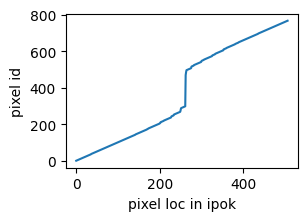

In [20]:
if verbose: 
    plt.figure(figsize=(3,2))
    plt.plot(ipok)
    plt.ylabel('pixel id')
    plt.xlabel('pixel loc in ipok')
    print('note how some of the pixels around the center are masked out')
    plt.show()

In [21]:
goesin = np.insert(bins.lmins,bins.nbins,bins.lmax+1)

In [22]:
ispec = np.zeros(nspec,int)
ispec[ispecs] = 1
if verbose: 
    print('ispec',ispec)

ispec [1 1 1 1 1 1]


In [23]:
Pl = np.ndarray(nbins*npix**2)

In [24]:
#lmax = nside
# lmax = 3 * nside - 1

In [100]:
file = 'Planck_PowSpec.txt'
# L TT TE EE BB PP
clth_planck = np.loadtxt('Planck_PowSpec.txt')
if verbose: print(clth_planck.shape)

(2507, 6)


In [101]:
clth = np.zeros((nspec,lmax+1))

In [102]:
print('lmin planck = ',int(clth_planck[0,0]))

lmin planck =  2


In [103]:
clth[0] = clth_planck[:lmax+1,1] # 'TT'
clth[1] = clth_planck[:lmax+1,3] # 'EE'
clth[2] = clth_planck[:lmax+1,4] # 'BB'
clth[4] = clth_planck[:lmax+1,4] # 'TE'

In [104]:
# # 'TT', 'EE', 'BB', 'TE', 'EB', 'TB'
# clth[3] =  # 'EB' -- define this unless you wish to have Pl zero for EB
# clth[5] =  # 'TB' -- define this unless you wish to have Pl zero for TB

In [76]:
from xqml.libcov import compute_ds_dcb

In [109]:
Pl, S = compute_ds_dcb(bins,
                       nside,
                       ipok,
                       bl,
                       clth,
                       Slmax,
                       spec,
                       pixwin=pixwin,
                       verbose=verbose,
                       openMP=True)

Construct Pl (npix=507): 1.1 sec


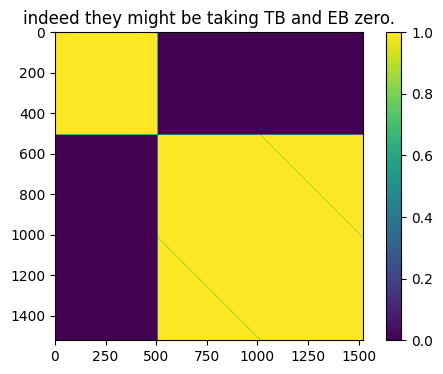

In [110]:
plt.figure(figsize=(6,4))
plt.title('indeed they might be taking TB and EB zero.')
plt.imshow(S!=0)
plt.colorbar()
plt.show()

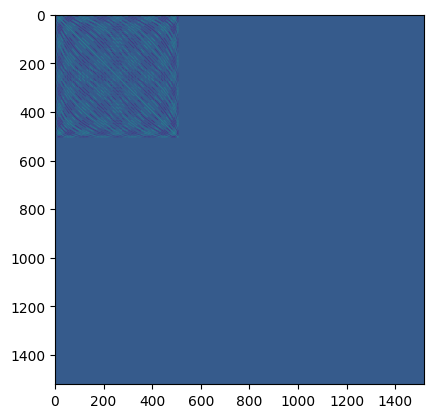

In [46]:
P

NameError: name 'P' is not defined

now let's finally fill up the Pl

In [87]:


clibcov.dSdC(nside, len(istokes), ispec, goesin, ipok, bell, Pl)

In [89]:
Pl

array([0.39594757, 0.39286027, 0.38978101, ..., 0.        , 0.        ,
       0.        ])

In [99]:
Pl = Pl.reshape( nbins, npix, npix)
P, Q = bins._bin_operators()

In [98]:
Pl.shape

(10175894784,)

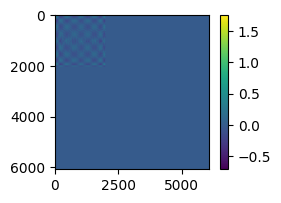

In [100]:
plt.figure(figsize=(3,2))
plt.imshow(Pl[10])
plt.colorbar()
plt.show()